# Creating the dataset

In [6]:
import torch
from torch import nn
import pandas as pd
from PIL import Image
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Creates a dataframe to extract the data
df = pd.read_csv('data/train.csv')

# Create the dataset and split it in train and test
X, y = np.array(df.loc[:, ~df.columns.isin(['label'])]), np.array(df['label'])
X, y = torch.tensor(X).type(torch.float), torch.tensor(y).type(torch.LongTensor)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([33600, 784]),
 torch.Size([8400, 784]),
 torch.Size([33600]),
 torch.Size([8400]))

# Vizualizing the images

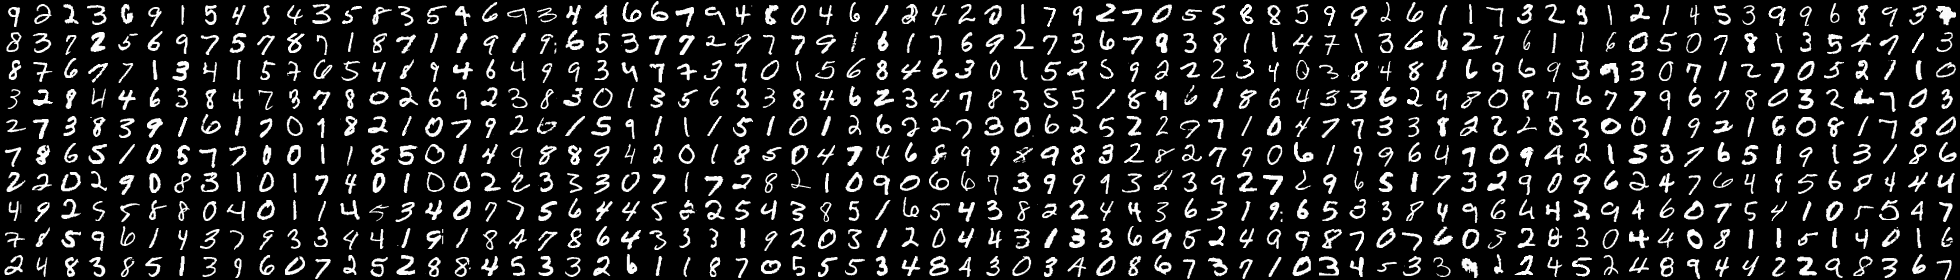

In [7]:
imgs = np.array(df.loc[:, ~df.columns.isin(['label'])])

# Defining the size of the matrix of numbers
MATRIX_WIDTH = 70
MATRIX_HEIGHT = 10

# The size of each image
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

# Creates the matrix
matrix = Image.new('L', (MATRIX_WIDTH * IMAGE_WIDTH, MATRIX_HEIGHT * IMAGE_HEIGHT))

# Put random images in the matrix
for i in range(MATRIX_HEIGHT):
    for j in range(MATRIX_WIDTH):
        image = Image.fromarray(imgs[random.randint(0, len(X))].reshape(28, 28).astype('uint8'), mode='L')
        x = j * IMAGE_WIDTH
        y = i * IMAGE_HEIGHT
        matrix.paste(image, (x, y))

display(matrix)

# The model

In [8]:
class MNIST(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.sequence = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.sequence(X)

model = MNIST()
display(model)

MNIST(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)

# Defining some hyperparameters

In [4]:
# Calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optmizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)

# Training

In [5]:
epochs = 500

for epoch in range(epochs):
    ### Train
    model.train()

    # 1. Forward
    pred = model(X_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)

    # 3. Backward
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    ### Testing
    model.eval()
    with torch.inference_mode():
        test_preds = torch.softmax(model(X_test), dim=1).argmax(dim=1)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 50 == 0:
        print('Epoch: {:<5d}    | Loss: {:<.5f}   | Acc: {:.2f}%'.format(epoch, loss, test_acc))

Epoch: 0       | Loss: 4.21867   | Acc: 13.50%
Epoch: 50      | Loss: 0.82245   | Acc: 74.11%
Epoch: 100     | Loss: 0.57193   | Acc: 81.64%
Epoch: 150     | Loss: 0.47045   | Acc: 84.55%
Epoch: 200     | Loss: 0.41168   | Acc: 86.54%
Epoch: 250     | Loss: 0.37205   | Acc: 87.56%
Epoch: 300     | Loss: 0.34287   | Acc: 88.48%
Epoch: 350     | Loss: 0.32024   | Acc: 89.15%
Epoch: 400     | Loss: 0.30188   | Acc: 89.71%
Epoch: 450     | Loss: 0.28654   | Acc: 90.20%
